In [63]:
# Import the data manipulation, visualisation and sql libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pandasql import sqldf
from geopy.geocoders import Nominatim

In [74]:
# Import the data in
country_codes = pd.read_excel('Country-Code.xlsx')
data = pd.read_csv('zomato.csv', encoding = "ISO-8859-1")
data.head()
country_codes.head()

,Country Code,Country
0,1,India
1,14,Australia
2,30,Brazil
3,37,Canada
4,94,Indonesia


/home/selvino/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Country', ylabel='count'>

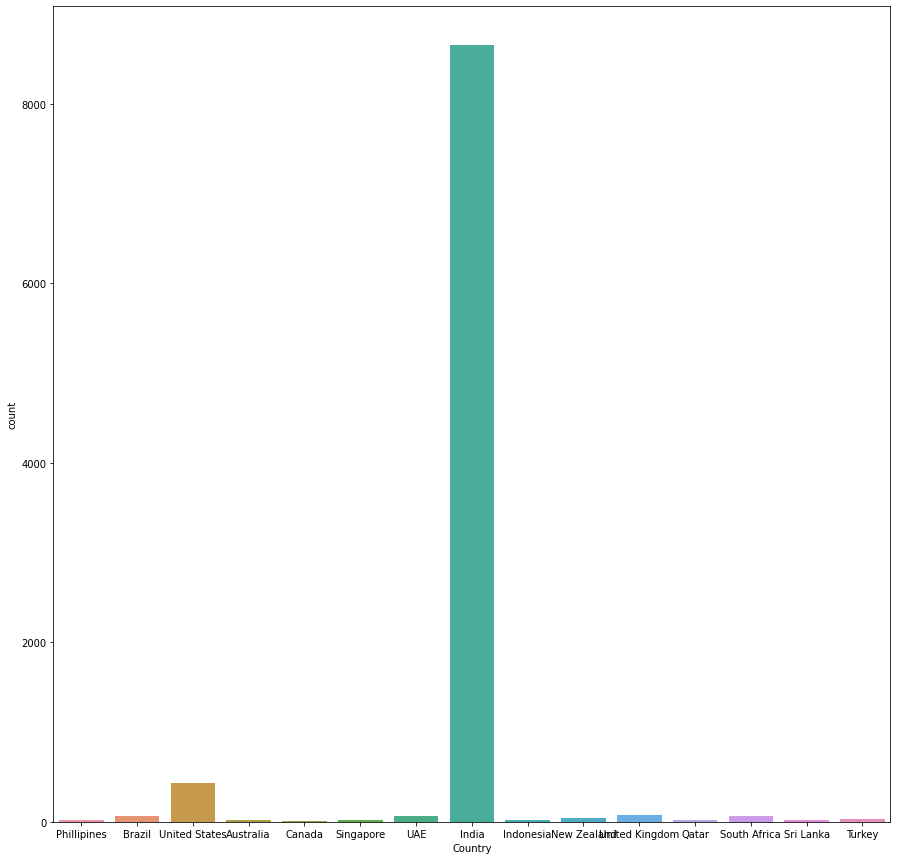

In [78]:
# Inner join the data on countries

q = """
    SELECT
        *
    FROM
        data
    JOIN
        country_codes
    ON
        data.[Country Code] = country_codes.[Country Code]
    ;

"""
plt.figure(figsize=(15,15))
sns.countplot(sqldf(q)['Country'])

0            City
1            City
2            City
3            City
4            City
          ...    
9546    ÛÁstanbul
9547    ÛÁstanbul
9548    ÛÁstanbul
9549    ÛÁstanbul
9550    ÛÁstanbul
Name: Country, Length: 9551, dtype: object

9551

['Luzon', 'Luzon', 'Luzon', 'Luzon', 'Luzon']